In [3]:
# Import modules
import os
import warnings
warnings.simplefilter("ignore", UserWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal as ss
import numpy as np

In [4]:
# Directories and files
DATA_DIR = "../../data/kosdaq/combined/"  # Using kospi data

In [5]:
# Load Data File List
file_list = os.listdir(DATA_DIR)
codes_list = [f[:-4] for f in file_list]

In [6]:
codes_list[:5]

['000250', '000440', '001000', '001540', '001810']

In [7]:
def ccf(x, y, lag_max = 100):
    result = ss.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)

    return result[lo:hi]

In [8]:
ncc_list = []
lag_list = []
company_values = {}
lag = 7
num_peaks = 20
scale_columns = ['volume', 'price', 'ratio']

for file in file_list:
    # Load File
    filepath= DATA_DIR + file
    df = pd.read_csv(filepath)
    
    if df.empty:
        print(file)
        continue
    
    # Scale
    df[scale_columns] -= df[scale_columns].min()
    df[scale_columns] /= df[scale_columns].max()
    df = df.dropna()
    
    # Find Peaks With High "Ratio" Values
    peaks = ss.find_peaks(df['ratio'].values, distance=7)[0]
    top_peaks = df.iloc[peaks,:]
    top_peaks = top_peaks.nlargest(num_peaks, 'ratio')
    # print(top_peaks)
    
    top_timeframes = {}
    # print(top_ten)
    
    # Create Timeframe For Each Peak
    for idx, row in top_peaks.iterrows():
        # print(row)
        start = idx-lag 
        end = idx+lag
        if start < 0 or end > len(df.index):
            continue
        # print("Start: ", start, "End: ", end)
        timeframe = df[start:end]
        top_timeframes[row['period']] = timeframe
        
    # print(top_timeframes)
        
    # Calculate Cross Correlation
    top_ncc = {}
    for peak, timeframe in top_timeframes.items():
        ncc = ccf(timeframe['price'].values, timeframe['ratio'].values,lag_max=lag)
        max_idx = np.argmax(abs(ncc))
        max_ncc = ncc[max_idx]
        max_lag = max_idx - lag 
        top_ncc[peak] = {
            "ncc": list(ncc),
            "max": [max_ncc, max_lag]
        }
        ncc_list.append(max_ncc)
        lag_list.append(max_lag)
        
    company_values[file[:-4]] = top_ncc
    # print(company_values)
    # print(file, max_ncc, max_lag)

C:\Users\bon12\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


158430.csv
234690.csv
330990.csv
331380.csv


In [9]:
# Find Company With Highest Average Correlation
max_avg = 0
max_company = ""

avg_list = []

for company, peak_info in company_values.items():
    # print(company)
    avg = np.mean([peak_values['max'][0] for peak_time, peak_values in peak_info.items()])
    avg_list.append([company, avg])
    if avg > max_avg:
        max_avg = avg
        max_company = company
        
print(max_company, max_avg)

027830 0.7369414625280829


C:\Users\bon12\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\bon12\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
# Find Top 10 Companies With Highest Average Correlation
sorted_avg_list = sorted(avg_list, key=lambda x:x[1])
print(sorted_avg_list[-10:])

[['900300', 0.4402093782956113], ['900310', 0.44212343470091425], ['900260', 0.4452587926630493], ['900070', 0.5345115248816055], ['900110', nan], ['900250', 0.4309812869909309], ['950110', 0.46439653557896265], ['271740', 0.6021801712249484], ['900270', 0.6032598530448108], ['950160', nan]]


C:\Users\bon12\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\bon12\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


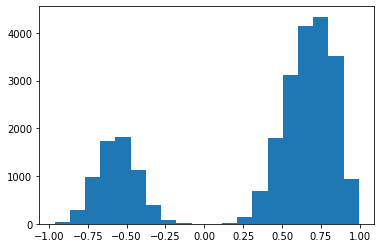

In [12]:
# Draw Histogram
plt.hist(ncc_list, 20)
plt.show()

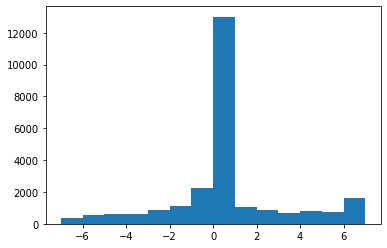

In [14]:
# Draw Histogram
plt.hist(lag_list, 14)
plt.show()

# 2. Look deeper into the company with highest average correlation

In [16]:
# Get timeframes for the company

company_values = {}
lag = 7
scale_columns = ['volume', 'price', 'ratio']


filepath= DATA_DIR + "025870.csv"
df = pd.read_csv(filepath)
df[scale_columns] -= df[scale_columns].min()
df[scale_columns] /= df[scale_columns].max()
df = df.dropna()

peaks = ss.find_peaks(df['ratio'].values, distance=7)[0]
top_peaks = df.iloc[peaks,:]
top_peaks = top_peaks.nlargest(20, 'ratio')
# print(top_peaks)


top_timeframes = {}
timeframes_list = []
# Create timeframe for each peak
for idx, row in top_peaks.iterrows():
    # print(row)
    start = idx-lag 
    end = idx+lag
    if start < 0 or end > len(df.index):
        continue
    # print("Start: ", start, "End: ", end)
    timeframe = df[start:end]
    top_timeframes[row['period']] = timeframe
    timeframes_list.append(timeframe)

print(timeframes_list[0])

         period     price    volume     ratio
912  2019-09-24  1.000000  0.741181  1.000000
809  2019-04-24  0.179228  1.000000  0.257537
603  2018-06-21  0.380515  0.768819  0.253036
230  2016-12-08  0.471507  0.452843  0.226318
179  2016-09-27  0.415441  0.321392  0.173668
888  2019-08-19  0.149816  0.312908  0.157951
880  2019-08-06  0.088235  0.364954  0.127090
801  2019-04-12  0.068934  0.487286  0.098871
256  2017-01-16  0.359375  0.247132  0.083941
237  2016-12-19  0.409007  0.093584  0.078868
59   2016-03-31  0.337316  0.083916  0.066367
394  2017-08-08  0.220588  0.334750  0.063438
210  2016-11-10  0.272978  0.028725  0.060151
615  2018-07-09  0.186581  0.236450  0.059509
219  2016-11-23  0.286765  0.109534  0.057794
383  2017-07-24  0.255515  0.150548  0.052722
550  2018-04-02  0.157169  0.140712  0.052722
662  2018-09-13  0.168199  0.143287  0.045792
834  2019-05-31  0.082721  0.135633  0.045292
270  2017-02-07  0.354779  0.043136  0.043292
         period     price    volum

19


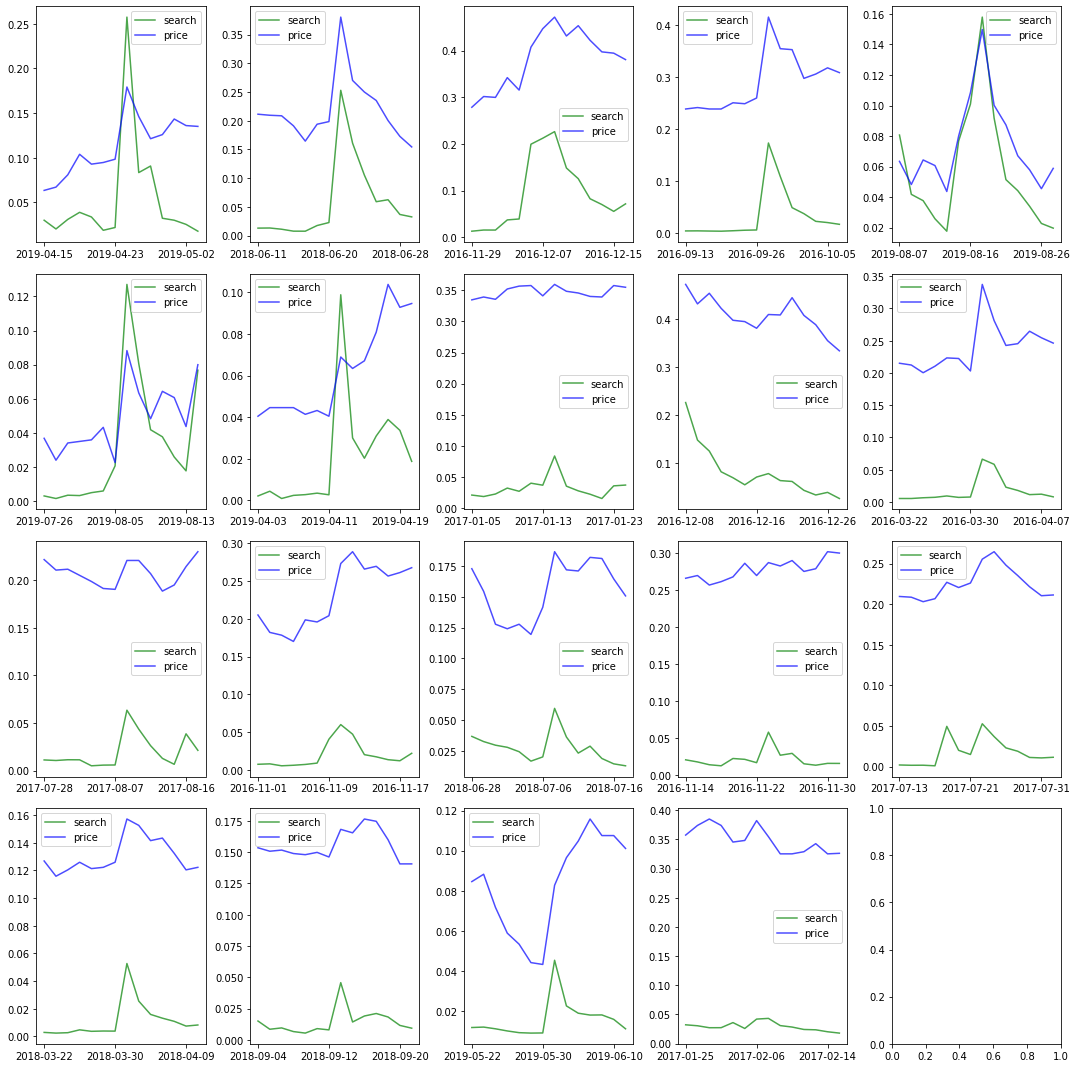

In [17]:
# Plot all the timeframes

fig, ax = plt.subplots(4,5, figsize=(15,15))
fig.tight_layout()
length = len(timeframes_list)
print(length)
for idx, t in enumerate(timeframes_list):
    dates = t['period'].values
    ratio = t['ratio'].values
    price = t['price'].values
    row = int(idx/5)
    col = int(idx%5)
    
    ax[row, col].plot(dates, ratio, label="search", color='green', alpha=0.7)
    ax[row, col].plot(dates, price, label="price", color='blue', alpha=0.7)
    ax[row, col].set_xticks(dates[::6])
    ax[row, col].set_xticklabels(dates[::6], rotation=0)
    ax[row, col].legend()